In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy


In [5]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []
    
    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }
    
    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")
        
        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue
            
            imgTrafficSignal = Image.open(image_path)
            imgTrafficSignal = imgTrafficSignal.convert("L")
            imgTrafficSignal = imgTrafficSignal.resize((90, 90))
            imgTrafficSignal = np.array(imgTrafficSignal)
            
            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                label_values = []
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # First value is the class ID
                    label_values.append(class_id)
            
            # Use only valid labels (remove -1 or any invalid labels)
            valid_labels = [label for label in label_values if label >= 0]
            
            if not valid_labels:
                print(f"No valid labels for {image_name}")
                continue
            
            # Use the first valid label
            first_label = valid_labels[0]
            
            if split_name == "train":
                train_data.append((imgTrafficSignal, first_label))
            elif split_name == "test":
                test_data.append((imgTrafficSignal, first_label))
            elif split_name == "valid":
                valid_data.append((imgTrafficSignal, first_label))
    
    return train_data, test_data, valid_data

In [7]:
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

No valid labels for FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.jpg
No valid labels for FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.jpg
No valid labels for FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.jpg
No valid labels for FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.jpg


In [11]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)

# Normalize the images
training_data_features = training_data_features / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

In [13]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(58, activation='softmax'))

(3527, 90, 90, 16)


In [15]:
cnnModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 23, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 58)                  │           6,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,560,702 (5.95 MB)

 Trainable params: 1,560,702 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 1)

# Train the model
history = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=12, 
    batch_size=32
)

Epoch 1/12


C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.0826 - loss: 2.9386 - val_accuracy: 0.1660 - val_loss: 2.5009
Epoch 2/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.2191 - loss: 2.4208 - val_accuracy: 0.3333 - val_loss: 2.0581
Epoch 3/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3239 - loss: 2.0320 - val_accuracy: 0.3708 - val_loss: 1.8830
Epoch 4/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.3991 - loss: 1.8068 - val_accuracy: 0.4270 - val_loss: 1.7208
Epoch 5/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4775 - loss: 1.5770 - val_accuracy: 0.4557 - val_loss: 1.6073
Epoch 6/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5528 - loss: 1.3424 - val_accuracy: 0.4582 - val_loss: 1.7057
Epoch 7/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6095 - loss: 1.1432 - val_accuracy: 0.5243 - val_loss: 1.5514
Epoch 8/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7285 - loss: 0.8393 - val_accurac

In [21]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


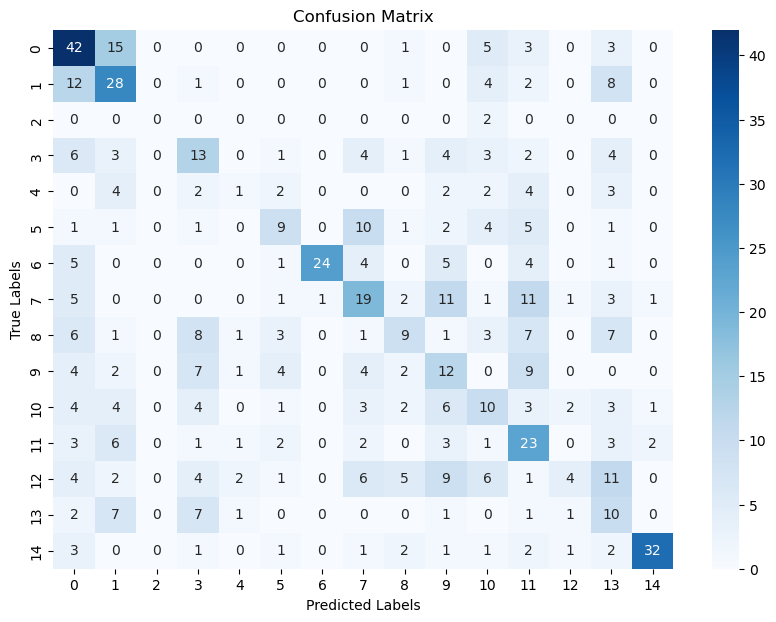

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 42
False Positive (FP): 55
False Negative (FN): 27
True Negative (TN): 513
Precision: 0.4330
Recall: 0.6087
F1-Score: 0.5060
Accuracy: 0.8713

Class 1:
True Positive (TP): 28
False Positive (FP): 45
False Negative (FN): 28
True Negative (TN): 536
Precision: 0.3836
Recall: 0.5000
F1-Score: 0.4341
Accuracy: 0.8854

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 2
True Negative (TN): 635
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.9969

Class 3:
True Positive (TP): 13
False Positive (FP): 36
False Negative (FN): 28
True Negative (TN): 560
Precision: 0.2653
Recall: 0.3171
F1-Score: 0.2889
Accuracy: 0.8995

Class 4:
True Positive (TP): 1
False Positive (FP): 6
False Negative (FN): 19
True Negative (TN): 611
Precision: 0.1429
Recall: 0.0500
F1-Score: 0.0741
Accuracy: 0.9608

Class 5:
True Positive (TP): 9
False Positive (FP): 17
False Negative (FN): 26
True Negative (TN): 585
Precision: 0.3462
Recall: 0.2571
F1-Score:

In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.43      0.61      0.51        69
           1       0.38      0.50      0.43        56
           2       0.00      0.00      0.00         2
           3       0.27      0.32      0.29        41
           4       0.14      0.05      0.07        20
           5       0.35      0.26      0.30        35
           6       0.96      0.55      0.70        44
           7       0.35      0.34      0.35        56
           8       0.35      0.19      0.25        47
           9       0.21      0.27      0.24        45
          10       0.24      0.23      0.24        43
          11       0.30      0.49      0.37        47
          12       0.44      0.07      0.12        55
          13       0.17      0.33      0.22        30
          14       0.89      0.68      0.77        47

    accuracy                           0.37       637
   macro avg       0.37      0.33      0.32       637
weighted avg       0.41   

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
